# Questions

## Increase in surface salinity in the arctic, is there some kind of trend in obersved data? What about models?

## How well does models represent the changes in salinity, and can they be used as a good indication for the future?

## How does sea surface salinity affect the vertical ocean circulation? And is this influence impactfull?

## What can we say about the sea surface salinity in the future, and how will this affect the vertical circulation in the arctic?


In [1]:
import functions as f
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import s3fs
import cftime
import intake
import numpy as np
from joblib import Parallel, delayed
from pyproj import Transformer
from datetime import datetime
import s3fs
%load_ext autoreload
%autoreload 2
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

## Satellite data

In [2]:
import time
path='escience2022/Antoine/ESA_SMOS_Arctic_Sea_Surface_Salinity/'
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
start = time.time()
sat_data = f.collect_satellite_data(years, path)
print(time.time()-start)

223.87508940696716


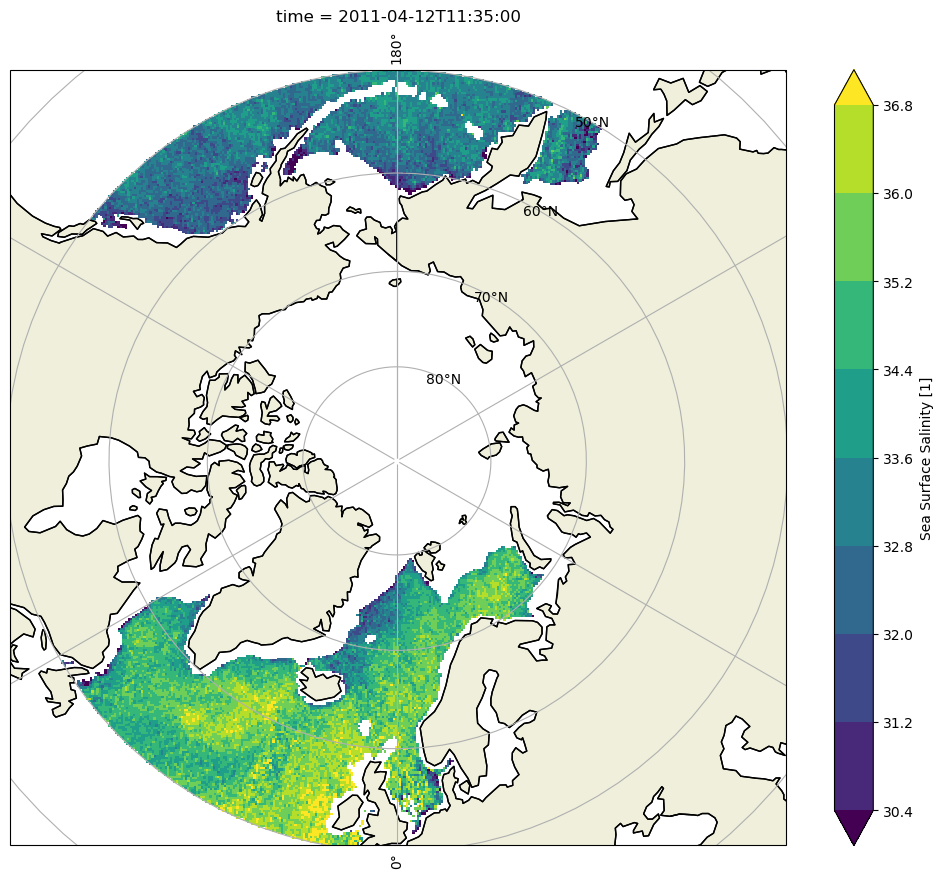

In [3]:
f.plot_sss_sat(sat_data['sss'][100])

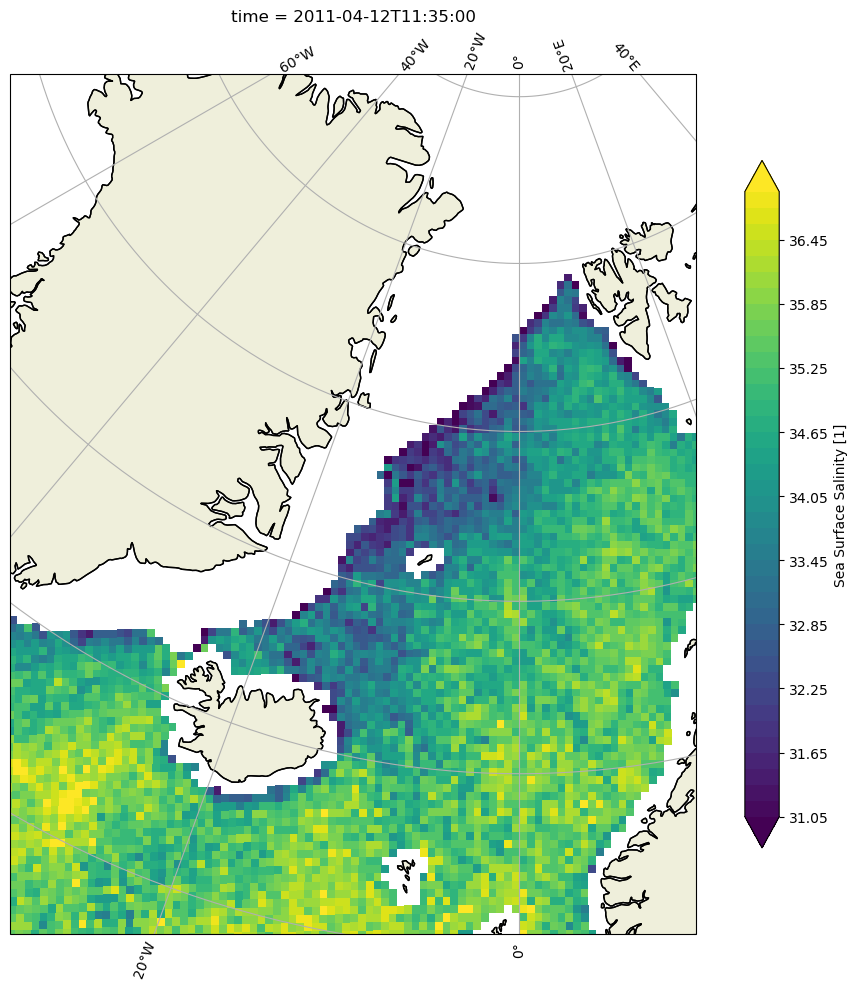

In [4]:
f.plot_sss_sat(sat_data['sss'][100], levels=50, extent=[-30,10,85,60], vmin=10, vmax=40)

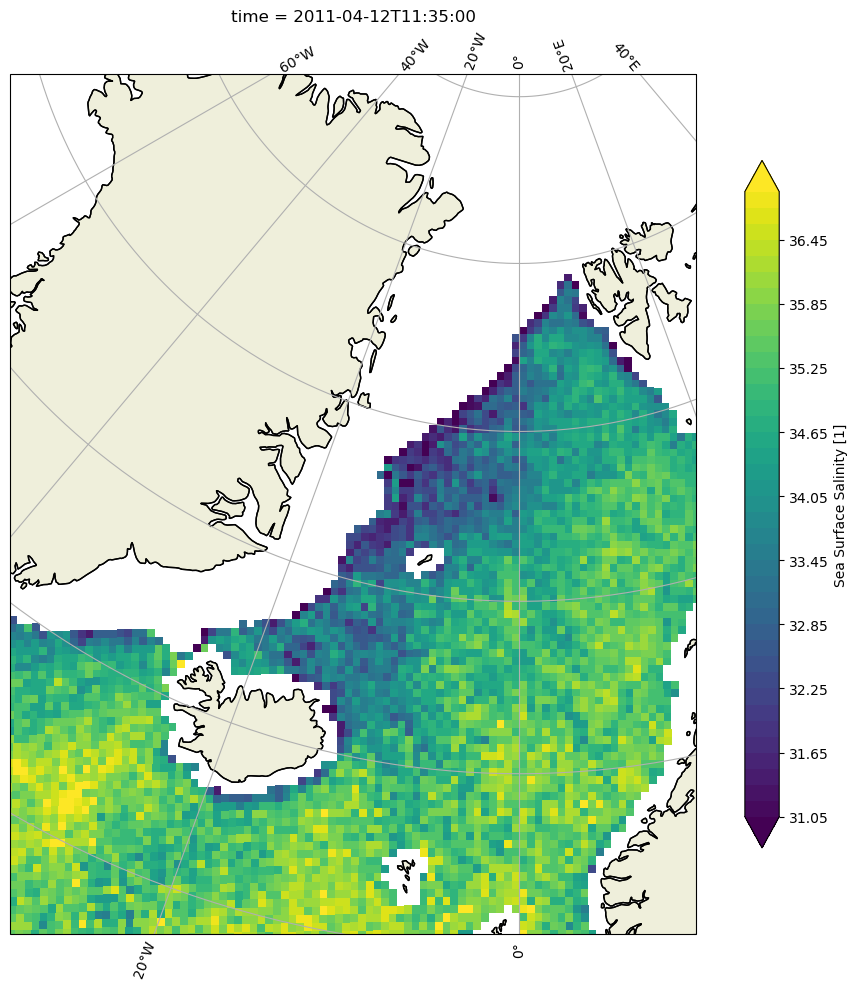

In [5]:
f.plot_sss_sat(sat_data['sss'][100], extent=[-30,10,85,60], levels=50, vmin=10, vmax=40)

In [6]:
SatRegion1 = f.slice_data(sat_data, '2012-01-01', '2012-02-01', -20, 5, 67, 90)

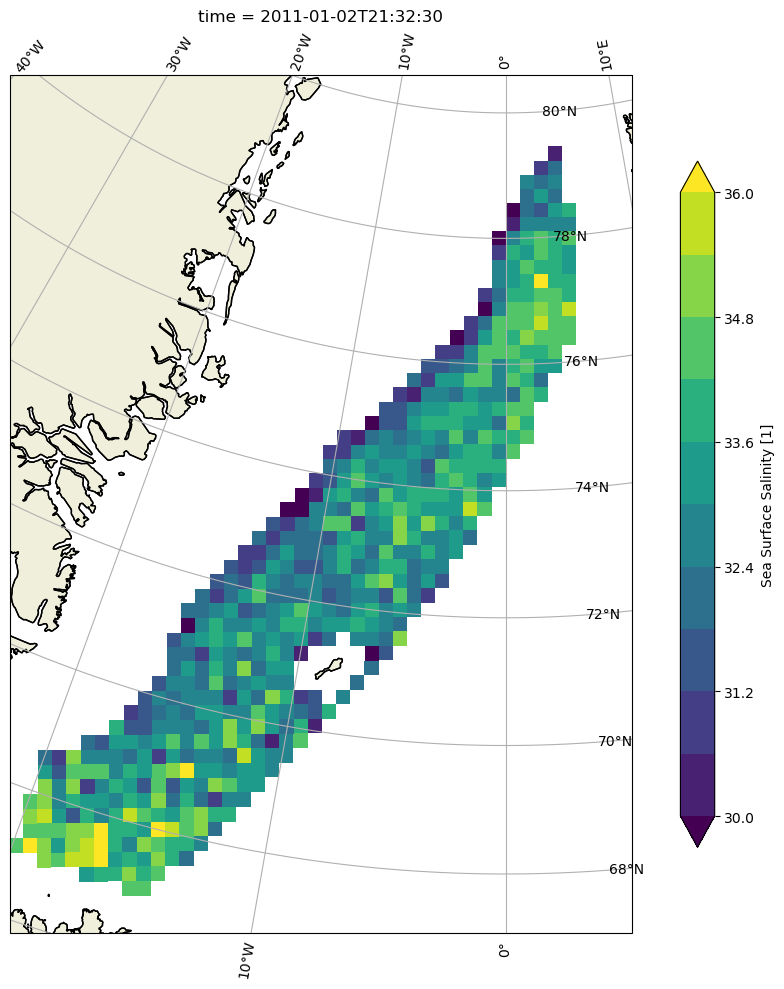

In [7]:

SatRegion1 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', -20, 5, 67, 90)

min_lat = np.min(SatRegion1['lat'])
min_lon = (np.min(SatRegion1['lon'][0]))
max_lat = np.max(SatRegion1['lat'])
max_lon = np.max(SatRegion1['lon'][0])

SatRegion1 = SatRegion1.where(SatRegion1['lat']-(SatRegion1['lon']/2) > min(min_lat-min_lon/2-1, max_lat-max_lon/2-1), drop=True)

f.plot_sss_sat(SatRegion1['sss'][0], extent = [-20,5,67,80])

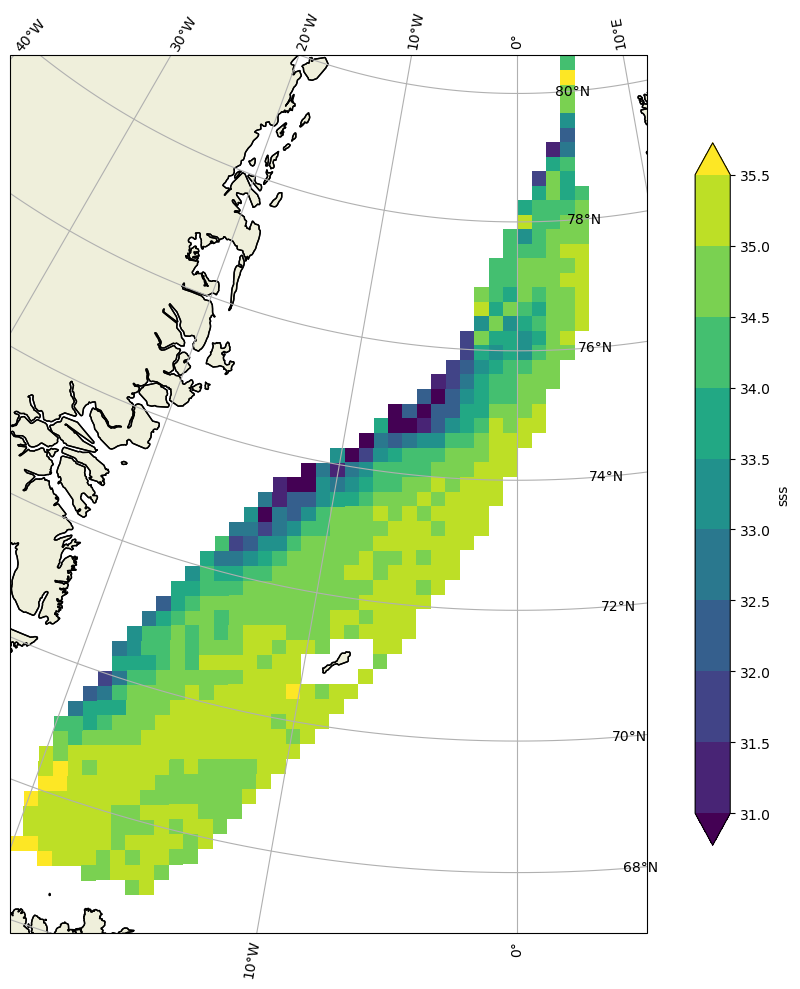

In [8]:
month = SatRegion1['time.month']
year = SatRegion1['time.year']
SatRegion1MeanJA = SatRegion1.where((month.isin(1)) & (year.isin(2013))).mean('time')
SatRegion1MeanJA['sss'].mean()
f.plot_sss_sat(SatRegion1MeanJA['sss'], extent = [-20,5,67,80])

## Seasonality

In [9]:
month = SatRegion1['time.month']
year = SatRegion1['time.year']
mean_list = []
for y in [2012,2013,2014,2015,2016,2017,2018,2019]:
    for m in [1,2,3,4,5,6,7,8,9,10,11,12]:
        tmp = SatRegion1.where((month.isin(m)) & (year.isin(y))).mean('time')
        mean_list.append(tmp['sss'].mean())

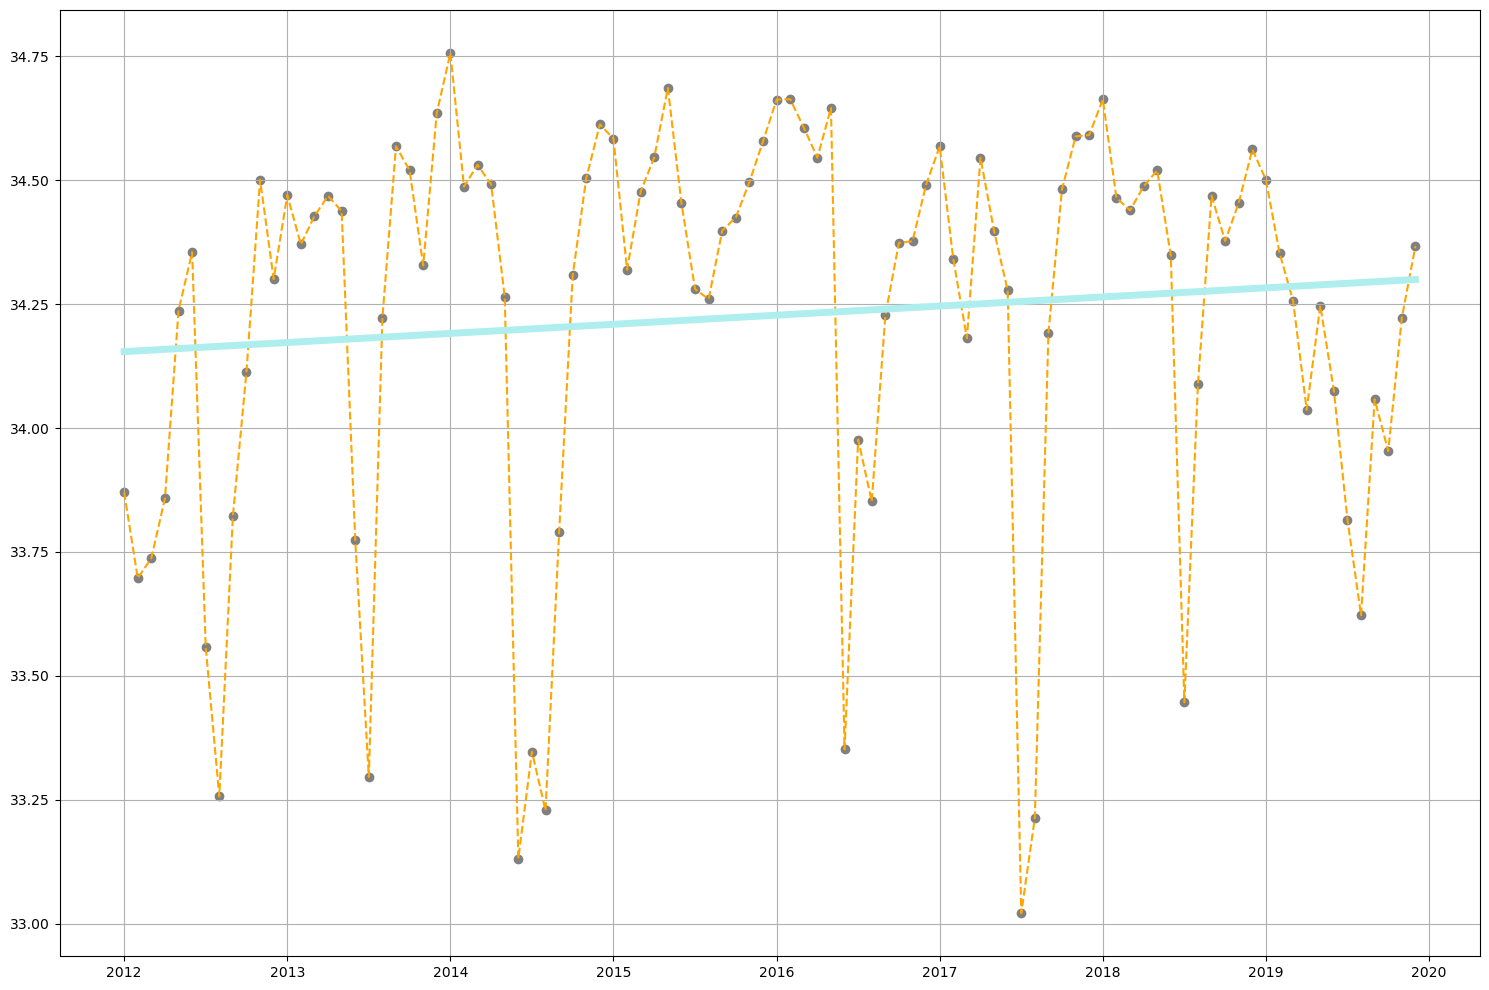

In [10]:
from scipy import stats
x = np.arange(0,12*8, 1)
ticks = [0,12,24,36,48,60,72,84,96]
dic = { 0:'2012', 12:'2013', 24:'2014', 36:'2015', 48:'2016', 60:'2017', 72:'2018', 84:'2019', 96:'2020'}
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

res = stats.linregress(x, mean_list)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(x, mean_list, '--', color='orange')
plt.scatter(x,mean_list, color='gray')
plt.plot(x, res.intercept + res.slope*x, color='paleturquoise', lw=5)
ax.set_xticks(ticks)

ax.set_xticklabels(labels)
plt.tight_layout()
plt.grid()

## ARGO data

In [11]:
_id = '3901591'
_id2 = '3901620'
argo_path = f's3://escience2022/Ada/ARGO/coriolis/{_id}/{_id}_prof.nc'
argo_path2 = f's3://escience2022/Ada/ARGO/coriolis/{_id2}/{_id2}_prof.nc'

In [12]:
Argo1 = xr.open_dataset(s3.open(argo_path))
Argo2 = xr.open_dataset(s3.open(argo_path2))

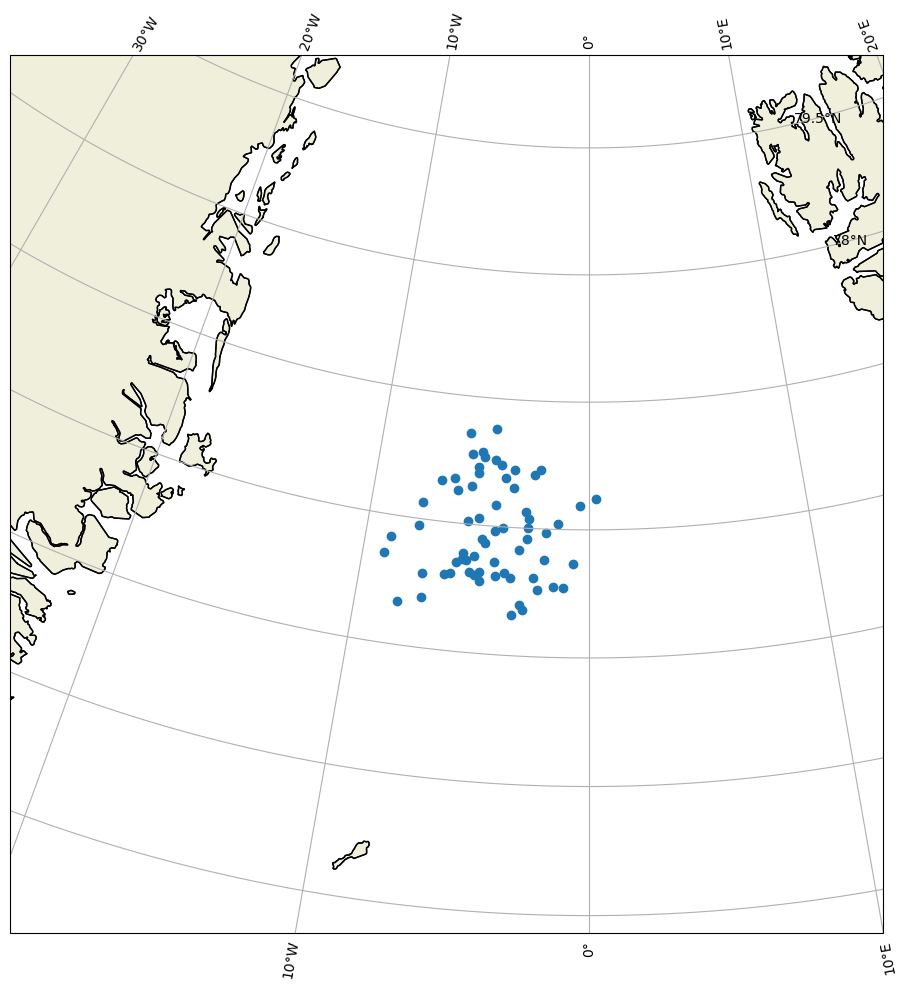

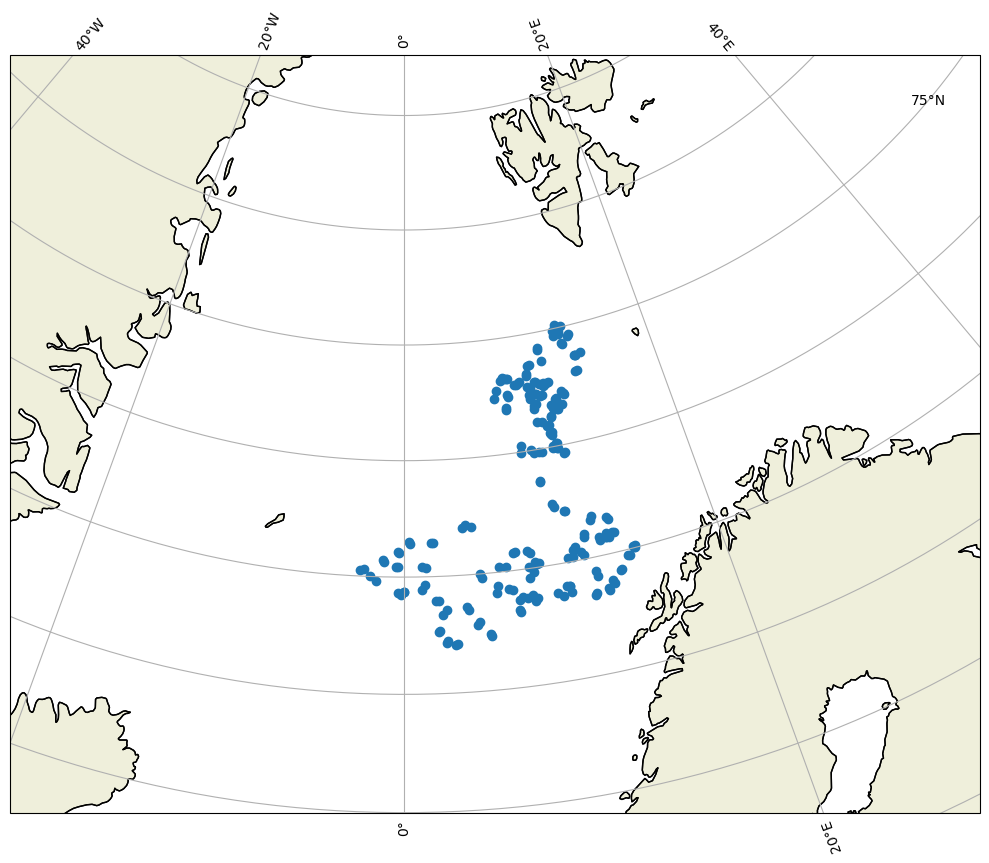

In [13]:
f.plot_argo_positions(Argo1, extent=[-20,10,80,70])
f.plot_argo_positions(Argo2, extent=[-20,30,80,65])

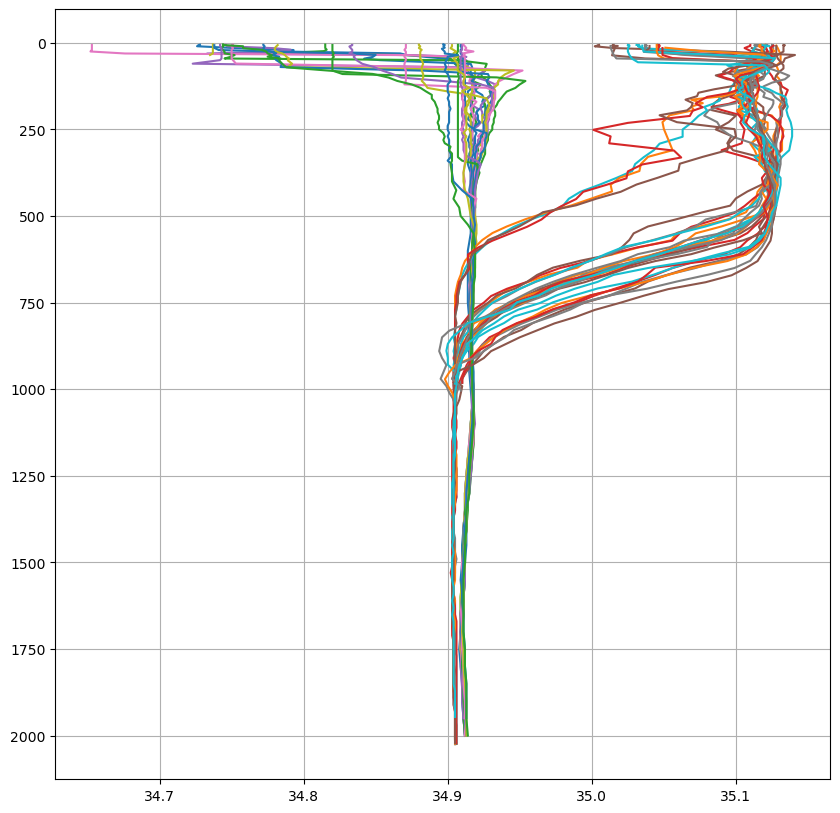

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(30):
    plt.plot(Argo1['PSAL_ADJUSTED'][i], Argo1['PRES'][i])
    plt.plot(Argo2['PSAL_ADJUSTED'][i], Argo2['PRES'][i])
plt.gca().invert_yaxis()
ax.grid()

## Model data

In [15]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id='so', source_id='UKESM1-0-LL', table_id='Omon', member_id='r2i1p1f2', activity_id='CMIP', experiment_id='historical')

cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708


In [16]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [17]:
ModelDataList = list(dset_dict.keys())
MDS = dset_dict[ModelDataList[0]].squeeze()
mds = MDS.sel(time='2010-10').sel(bnds=0).sel(lev=1, method='nearest').sel(vertices=0).squeeze()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


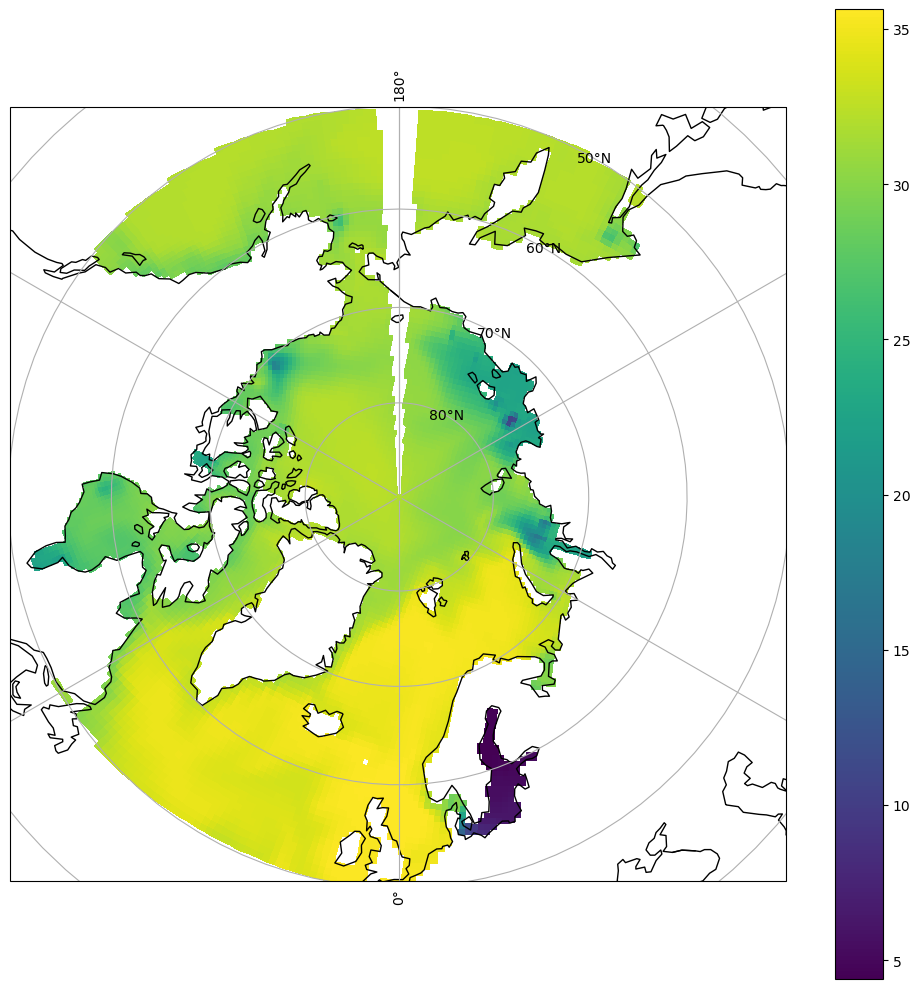

In [18]:
cut = f.slice_data(mds, min_lat = 50, max_lat = 90, min_lon = -177, max_lon = 177)
f.PlotModel(cut, [-177,177,90,50])

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


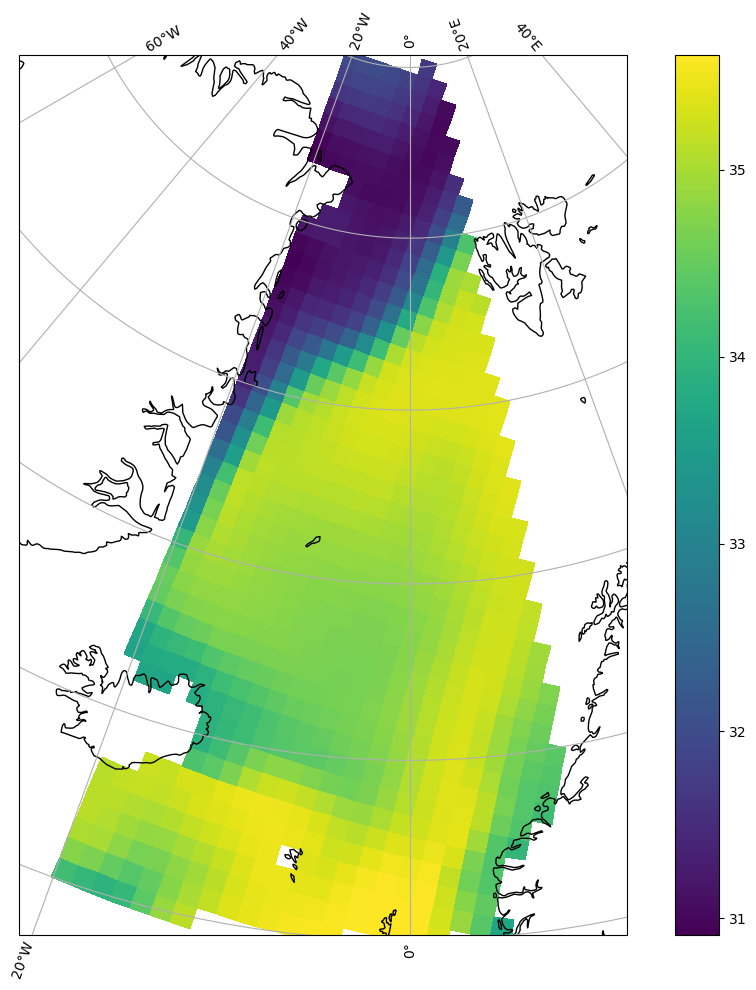

In [19]:
cut = f.slice_data(cut, min_lat = 60, max_lat = 85, min_lon = -20, max_lon = 10)
f.PlotModel(cut, extent=[-22,12,60,85])

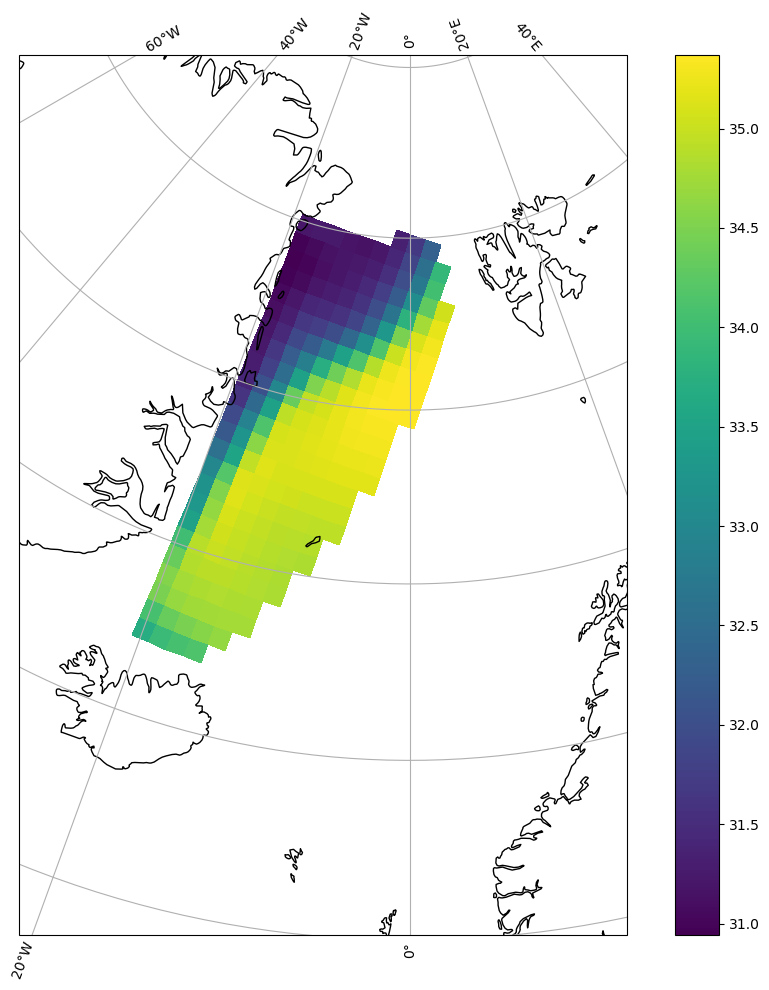

In [20]:
a = f.slice_data(cut, min_lon = -20, max_lon=5, min_lat = 67, max_lat = 80)

min_lat = np.min(a['latitude'])
min_lon = (np.min(a['longitude'][0]))
max_lat = np.max(a['latitude'])
max_lon = np.max(a['longitude'][0])

a = a.where(a['latitude']-(a['longitude']/2) > min(min_lat-min_lon/2-1, max_lat-max_lon/2-1), drop=True)
f.PlotModel(a,extent=[-22,12,60,85])

In [21]:
month = MDS['time.month']
month

<xarray.DataArray 'month' (time: 1980)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
    member_id  <U8 'r2i1p1f2'

In [22]:
y2001 = MDS.sel(time='2001').sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)
y2001 = f.slice_data(y2001, min_lon = -20, max_lon=5, min_lat = 67, max_lat = 80)


min_lat = np.min(y2001['latitude'])
min_lon = (np.min(y2001['longitude'][0]))
max_lat = np.max(y2001['latitude'])
max_lon = np.max(y2001['longitude'][0])

y2001 = y2001.where(y2001['latitude']-(y2001['longitude']/2) > min(min_lat-min_lon/2-1, max_lat-max_lon/2-1), drop=True)

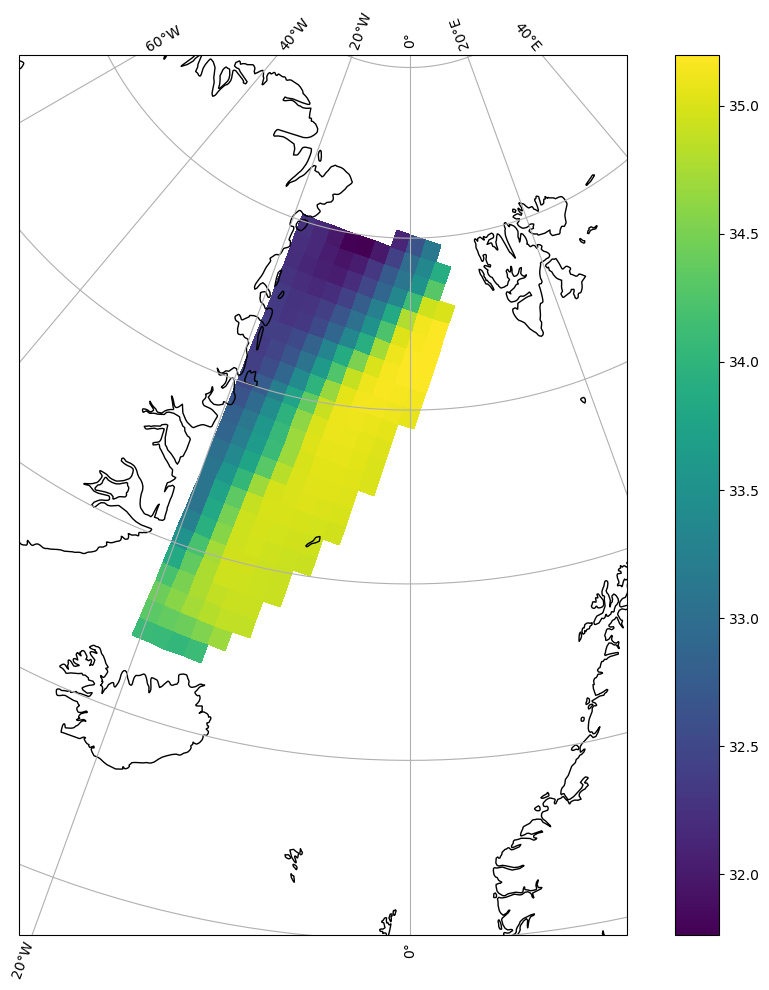

In [23]:
mean = y2001.where(month.isin(month)).mean('time')
mean

f.PlotModel(mean, extent=[-22,12,60,85])

In [30]:
area = MDS.sel(time = slice('1950','2015')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)
area = f.slice_data(area, min_lon = -20, max_lon=5, min_lat = 67, max_lat = 80)

min_lat = np.min(area['latitude'])
min_lon = (np.min(area['longitude'][0]))
max_lat = np.max(area['latitude'])
max_lon = np.max(area['longitude'][0])

area = area.where(area['latitude']-(area['longitude']/2) > min(min_lat-min_lon/2-1, max_lat-max_lon/2-1), drop=True)


mean = area['so'].groupby('time.month').mean(dim='time').mean('i').mean('j').compute()
t = area['so'].mean('i').mean('j').compute().groupby('time.month')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


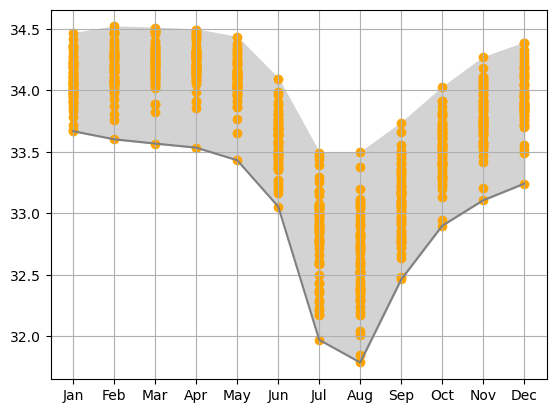

In [49]:
month=area['time.month']
year=area['time.year']
years = np.arange(1950,2015,1)
x = np.arange(1,13,1)

fig, ax = plt.subplots()
max_ = []
min_ = []
for month in t.groups.keys():
    max_.append(np.max(t[month]))
    min_.append(np.min(t[month]))
ax.fill_between(x, min_, max_, color='lightgray')
for month in t.groups.keys():
    m = np.full(len(t[month]), month)
    plt.scatter(m, t[month], color='orange')

#Parallel(n_jobs=12)(delayed(_MonthData)(month) for month in t.groups.keys())
plt.plot(x, mean, 'red', lw=5)
#plt.plot(x, max_, 'gray')
#plt.plot(x, min_, 'gray')
plt.grid()
ticks = [1,2,3,4,5,6,7,8,9,10,11,12]

dic = { 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.show()

In [25]:
t = area['so'].mean('i').mean('j').groupby('time.month')

def _MonthData(month):
    m = np.full(len(t[month]), month)
    plt.scatter(m, t[month])
plt.show()

Parallel(n_jobs=12)(delayed(_MonthData)(month) for month in t.groups.keys())

[None, None, None, None, None, None, None, None, None, None, None, None]